 # 第三部分：Milvus 应用实践 - RAG, Agent 与图片搜索案例

 欢迎来到 Milvus Workshop 的第三部分！在这一部分，我们将把前面学到的 Milvus 基础知识应用到一些实际的案例中，包括图片搜索、以及未来可能扩展到的 RAG (Retrieval Augmented Generation) 和 Agent 应用。

 ## 3.1 Milvus 在图片搜索中的应用

 图片搜索是向量数据库的一个经典应用场景。无论是“以图搜图”（找到与给定图片相似的其他图片）还是“以文搜图”（根据文本描述找到匹配的图片），其核心都是将图片（或文本）转换为高维向量（Embedding），然后在向量空间中进行相似性查找。

 ### 流程：图片加载 -> 图片向量化 (Embedding) -> 存储 -> 检索

 一个典型的图片搜索系统通常包含以下步骤：

 1.  **图片加载与预处理**:
     *   从磁盘、URL 或数据库加载图片。
     *   对图片进行必要的预处理，如调整大小、归一化等，以匹配预训练模型对输入的要求。

 2.  **图片向量化 (Embedding)**:
     *   使用预训练的深度学习模型（如 ResNet, VGG, EfficientNet, CLIP, ViT 等）提取图片的特征向量。
     *   这些模型能够将图片的视觉内容转换成一个固定维度的数值型向量，相似的图片在向量空间中距离会更近。
     *   对于“以文搜图”，则需要能同时处理文本和图片的多模态模型 (如 CLIP)，将文本描述也转换到与图片向量相同的语义空间。

 3.  **存储 (Ingestion to Milvus)**:
     *   将每张图片的唯一标识符（如文件路径、ID）和其对应的特征向量存储到 Milvus Collection 中。
     *   为向量字段创建合适的索引以加速后续的检索过程。

 4.  **检索 (Search/Query)**:
     *   **以图搜图**:
         1.  对输入的查询图片执行与步骤1、2相同的加载、预处理和向量化操作，得到查询向量。
         2.  使用查询向量在 Milvus 中执行向量相似度搜索，找到 Top-K 个最相似的图片向量。
         3.  返回这些相似图片的标识符。
     *   **以文搜图 (需要多模态模型)**:
         1.  使用多模态模型的文本编码器将输入的文本描述转换为查询向量。
         2.  使用查询向量在 Milvus 中（存储的是图片向量）执行向量相似度搜索。
         3.  返回与文本描述最相关的图片的标识符。

 ### Milvus 在图片搜索中的角色

 - **存储图片特征向量**: Milvus 高效地存储和管理由深度学习模型生成的数百万甚至数十亿级别的图片特征向量。
 - **实现高效相似性搜索**: 利用其内置的多种向量索引和 ANNS 算法，Milvus 能够快速地从海量图片向量中检索出与查询向量（来自图片或文本）最相似的结果。
 - **可扩展性和可靠性**: Milvus 的分布式架构使其能够处理大规模图片数据集，并提供高可用性和数据持久性。

 ### 案例演示/代码讲解：构建一个简单的图片搜索 Demo

 我们将构建一个非常基础的“以图搜图”演示。

 **步骤概览:**
 1.  **环境准备**: 安装必要的库。
 2.  **准备图片数据集**: 使用少量示例图片。
 3.  **选择预训练模型**: 我们将使用 `torchvision` 提供的预训练的 ResNet 模型提取特征，并进行简单的降维 (可选)。为了更现代的演示，使用 CLIP 会更好，但其设置和依赖稍微复杂一些。
 4.  **创建 Milvus Collection**: 用于存储图片路径和向量。
 5.  **图片向量化并插入 Milvus**。
 6.  **实现搜索功能**。


 #### 1. 环境准备与导入库

 **请确保您已安装以下库:**

 ```bash
 pip install timm torch numpy sklearn pillow pymilvus
 ```

In [10]:
import os
import random
import shutil
import torch
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# Milvus Client
from pymilvus import MilvusClient, DataType, FieldSchema, CollectionSchema

# 用于显示图片 (在 Jupyter Notebook 中)
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"Pillow version: {Image.__version__}")



PyTorch version: 2.7.0+cu126
Pillow version: 10.4.0


 #### 2. 准备图片数据集

我们需要一些图片。为了演示，我们可以从网上下载少量图片，或者使用本地已有的图片。
这里我们创建一个简单的函数来下载一些示例图片 (如果运行环境允许网络访问)。

准备下载示例图片...

成功下载/准备了 10 张示例图片到 'milvus_image_search_data' 目录。


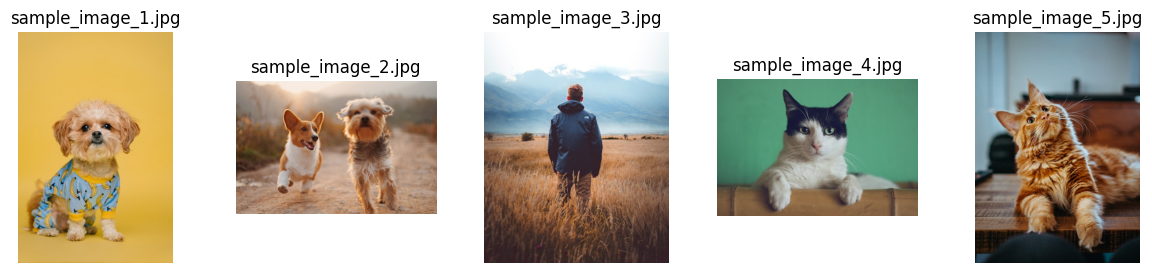

In [4]:
# --- 图片数据集准备 ---
IMAGE_DATA_DIR = "milvus_image_search_data"
SAMPLE_IMAGE_URLS = [
    "https://images.unsplash.com/photo-1583511655826-05700d52f4d9?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # Dog
    "https://images.unsplash.com/photo-1548199973-03cce0bbc87b?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # Dogs playing
    "https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # Person
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # Cat
    "https://images.unsplash.com/photo-1573865526739-10659fec78a5?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # Another Cat
    "https://images.unsplash.com/photo-1481349518771-20055b2a7b24?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # Banana
    "https://images.unsplash.com/photo-1528825871115-3581a5387919?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # More Bananas
    "https://images.unsplash.com/photo-1502672260266-1c1ef2d93688?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # Cityscape
    "https://images.unsplash.com/photo-1506260408121-e353d10b87c7?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max", # Landscape
    "https://images.unsplash.com/photo-1533743983669-94fa5c4338ec?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=400&fit=max"  # Car
]

# 清理并创建图片目录
if os.path.exists(IMAGE_DATA_DIR):
    shutil.rmtree(IMAGE_DATA_DIR)
os.makedirs(IMAGE_DATA_DIR, exist_ok=True)

import requests
def download_image(url, folder, filename):
    try:
        response = requests.get(url, stream=True, timeout=10)
        response.raise_for_status()
        filepath = os.path.join(folder, filename)
        with open(filepath, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        # print(f"Downloaded {filename}")
        return filepath
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return None

image_paths = []
print("准备下载示例图片...")
for i, url in enumerate(SAMPLE_IMAGE_URLS):
    filename = f"sample_image_{i+1}.jpg"
    path = download_image(url, IMAGE_DATA_DIR, filename)
    if path:
        image_paths.append(path)

if not image_paths:
    print("未能下载任何示例图片。请确保网络连接正常或手动准备图片到 '" + IMAGE_DATA_DIR + "' 目录下。")
    # 在此可以引导用户手动添加图片或停止
    # raise RuntimeError("无法获取示例图片，演示无法继续。")
else:
    print(f"\n成功下载/准备了 {len(image_paths)} 张示例图片到 '{IMAGE_DATA_DIR}' 目录。")
    # 显示几张下载的图片
    fig, axes = plt.subplots(1, min(5, len(image_paths)), figsize=(15, 3))
    if len(image_paths) == 1 and min(5, len(image_paths)) == 1: # 处理只有一个图的情况
        axes = [axes]
    for i, img_path in enumerate(image_paths[:5]):
        try:
            img = Image.open(img_path).convert("RGB")
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(img_path))
            axes[i].axis('off')
        except Exception as e:
            print(f"无法显示图片 {img_path}: {e}")
    plt.show()

 #### 3. 选择预训练模型并定义特征提取函数

 我们使用 ResNet-34 模型来提取图片的Embedding信息。


In [5]:
import torch
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


class FeatureExtractor:
    def __init__(self, modelname):
        # Load the pre-trained model
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # Get the input size required by the model
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=modelname)
        # Get the preprocessing function provided by TIMM for the model
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        # Preprocess the input image
        input_image = Image.open(imagepath).convert("RGB")  # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # Convert the image to a PyTorch tensor and add a batch dimension
        input_tensor = input_image.unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # Extract the feature vector
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()

 #### 4. 创建 Milvus Collection

 我们需要一个 Collection 来存储图片路径 (作为主键) 和提取的特征向量。

In [6]:
MILVUS_HOST_IMG = "localhost"
MILVUS_PORT_IMG = "19530"
MILVUS_URI_IMG = f"http://{MILVUS_HOST_IMG}:{MILVUS_PORT_IMG}"

IMG_COLLECTION_NAME = "milvus_image_demo_collection"
IMG_ID_FIELD = "image_id" # 存储图片路径或唯一ID
IMG_VECTOR_FIELD = "image_vector"
VECTOR_DIMENSION = 512

# 连接 Milvus
try:
    img_milvus_client = MilvusClient(uri=MILVUS_URI_IMG)
    print(f"成功连接到 Milvus 服务: {MILVUS_URI_IMG}")
except Exception as e:
    print(f"连接 Milvus 服务失败: {e}")
    raise

# 检查并删除旧的 Collection (用于演示的可重入性)
if img_milvus_client.has_collection(collection_name=IMG_COLLECTION_NAME):
    print(f"发现已存在的 Collection '{IMG_COLLECTION_NAME}', 将其删除。")
    img_milvus_client.drop_collection(collection_name=IMG_COLLECTION_NAME)

# 定义 Schema
# 主键：存储图片路径或唯一ID，VARCHAR 类型
id_field = FieldSchema(name=IMG_ID_FIELD, dtype=DataType.VARCHAR, is_primary=True, max_length=1024, auto_id=False)
# 向量字段：存储图片特征向量
vector_field = FieldSchema(name=IMG_VECTOR_FIELD, dtype=DataType.FLOAT_VECTOR, dim=VECTOR_DIMENSION)

schema = CollectionSchema(
    fields=[id_field, vector_field],
    description="Collection for image similarity search demo",
    enable_dynamic_field=False # 通常对于固定 Schema 设为 False
)

# 创建 Collection
try:
    img_milvus_client.create_collection(
        collection_name=IMG_COLLECTION_NAME,
        schema=schema,
        consistency_level="Strong" # 确保插入后可立即查询
    )
    print(f"Collection '{IMG_COLLECTION_NAME}' 创建成功。")
    print(f"Schema: ID({IMG_ID_FIELD}, VARCHAR), Vector({IMG_VECTOR_FIELD}, FLOAT_VECTOR, dim={VECTOR_DIMENSION})")
except Exception as e:
    print(f"创建 Collection '{IMG_COLLECTION_NAME}' 失败: {e}")
    raise


成功连接到 Milvus 服务: http://localhost:19530
发现已存在的 Collection 'milvus_image_demo_collection', 将其删除。
Collection 'milvus_image_demo_collection' 创建成功。
Schema: ID(image_id, VARCHAR), Vector(image_vector, FLOAT_VECTOR, dim=512)


 #### 5. 图片向量化并插入 Milvus

In [7]:
import os

extractor = FeatureExtractor("resnet34")

root = "./"+IMAGE_DATA_DIR

print(f"\n准备将图片的特征向量插入 Milvus...")
for dirpath, foldername, filenames in os.walk(root):
    for filename in filenames:
        if filename.endswith(".jpg"):
            filepath = dirpath + "/" + filename
            image_embedding = extractor(filepath)
            img_milvus_client.insert(
                IMG_COLLECTION_NAME,
                {IMG_VECTOR_FIELD: image_embedding, IMG_ID_FIELD: filepath},
            )

print("Flushing collection...")
img_milvus_client.flush(collection_name=IMG_COLLECTION_NAME)
print("Flush 完成。")

# 检查实体数量
stats_after_insert = img_milvus_client.get_collection_stats(collection_name=IMG_COLLECTION_NAME)
print(f"Collection '{IMG_COLLECTION_NAME}' 当前实体数量: {stats_after_insert.get('row_count')}")



准备将图片的特征向量插入 Milvus...
Flushing collection...
Flush 完成。
Collection 'milvus_image_demo_collection' 当前实体数量: 10


#### 5.1 (重要) 为向量字段创建索引

为了高效搜索，我们需要为 `IMG_VECTOR_FIELD` 创建索引。

In [8]:
# --- 创建索引 ---
IDX_NAME = "idx_img_embedding_hnsw"

if img_milvus_client.has_collection(IMG_COLLECTION_NAME) and int(img_milvus_client.get_collection_stats(IMG_COLLECTION_NAME).get('row_count',0)) > 0 :
    print(f"\n为 Collection '{IMG_COLLECTION_NAME}' 的字段 '{IMG_VECTOR_FIELD}' 创建索引...")
    
    # 检查是否已存在索引，如果存在则先删除
    existing_indexes_img = img_milvus_client.list_indexes(collection_name=IMG_COLLECTION_NAME)
    if any(idx_info == IDX_NAME for idx_info in existing_indexes_img):
        print(f"字段 '{IMG_VECTOR_FIELD}' 上已存在索引，将删除旧索引。")
        try:
            img_milvus_client.drop_index(collection_name=IMG_COLLECTION_NAME, index_name=IDX_NAME)
            print("旧索引已删除。")
        except Exception as e_drop_idx:
            print(f"删除旧索引失败: {e_drop_idx}")

    # HNSW 索引参数
    img_index_params = MilvusClient.prepare_index_params()

    img_index_params.add_index(
        field_name=IMG_VECTOR_FIELD,
        metric_type="L2",
        index_type="HNSW",
        index_name=IDX_NAME,
        params={
            "M": 8,              # 每个节点的最大连接数 (较小值，构建快)
            "efConstruction": 100 # 构建图时的搜索范围 (较小值，构建快)
        }
    )
    try:
        img_milvus_client.create_index(
            collection_name=IMG_COLLECTION_NAME,
            index_params=img_index_params
        )
        print(f"索引创建请求已发送。参数: {img_index_params}")
        
        # 等待索引构建完成 (对于小数据量，这通常很快)
        print("等待索引构建完成...")

    except Exception as e:
        print(f"创建索引失败: {e}")
else:
    print(f"\nCollection '{IMG_COLLECTION_NAME}' 不存在或为空，跳过索引创建。")


为 Collection 'milvus_image_demo_collection' 的字段 'image_vector' 创建索引...
索引创建请求已发送。参数: [{'field_name': 'image_vector', 'index_type': 'HNSW', 'index_name': 'idx_img_embedding_hnsw', 'M': 8, 'efConstruction': 100, 'metric_type': 'L2'}]
等待索引构建完成...


 #### 6. 实现搜索功能 (以图搜图)


搜索与图片 'sample_image_4.jpg' 相似的图片 (Top 2)...


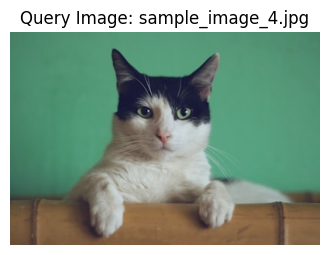


搜索结果:
  - 结果 #1: ID='./milvus_image_search_data/sample_image_4.jpg', 距离=0.0000, 路径='./milvus_image_search_data/sample_image_4.jpg'
  - 结果 #2: ID='./milvus_image_search_data/sample_image_5.jpg', 距离=0.4478, 路径='./milvus_image_search_data/sample_image_5.jpg'


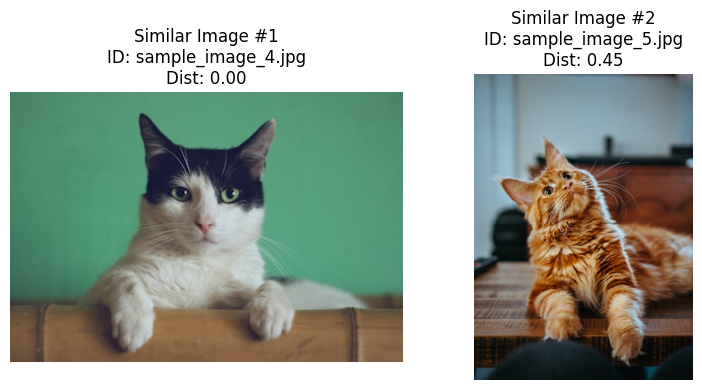

In [19]:
import warnings

# Suppress the specific UserWarning from pylabtools
warnings.filterwarnings("ignore", category=UserWarning, module="pylabtools", lineno=152)

def search_similar_images(query_image_path, top_k=3):
    if not img_milvus_client.has_collection(IMG_COLLECTION_NAME):
        print(f"错误: Collection '{IMG_COLLECTION_NAME}' 不存在。")
        return

    print(f"\n搜索与图片 '{os.path.basename(query_image_path)}' 相似的图片 (Top {top_k})...")

    # 1. 确保 Collection 已加载
    try:
        img_milvus_client.load_collection(collection_name=IMG_COLLECTION_NAME)
        # print(f"Collection '{IMG_COLLECTION_NAME}' 已加载。")
    except Exception as e:
        print(f"加载 Collection 失败: {e}")
        return

    # 2. 提取查询图片的特征向量
    query_vectors_for_search = [extractor(query_image_path)] # search API 需要 list of lists

    # 3. 定义搜索参数
    search_params_img = {
        "metric_type": "L2", # 与索引创建时一致
        "params": {"ef": 32} # HNSW 搜索参数，ef >= top_k
    }

    # 4. 执行搜索
    try:
        results = img_milvus_client.search(
            collection_name=IMG_COLLECTION_NAME,
            data=query_vectors_for_search,
            anns_field=IMG_VECTOR_FIELD,
            limit=top_k,
            search_params=search_params_img,
            output_fields=[IMG_ID_FIELD] # 我们需要图片路径/ID
        )
        
        # 显示查询图片
        plt.figure(figsize=(4,4))
        query_img_display = Image.open(query_image_path).convert("RGB")
        plt.imshow(query_img_display)
        plt.title(f"Query Image: {os.path.basename(query_image_path)}")
        plt.axis('off')
        plt.show()

        print("\n搜索结果:")
        if not results or not results[0]:
            print("  没有找到相似的图片。")
            return

        # 显示结果图片
        num_results = len(results[0])
        fig, axes = plt.subplots(1, num_results, figsize=(num_results * 4, 4))
        if num_results == 1: axes = [axes] # 处理单个结果的情况

        for i, hit in enumerate(results[0]):
            result_id = hit.get(IMG_ID_FIELD) # 这是存储的图片标识符
            distance = hit.get('distance')
            
            result_image_path = result_id
            
            print(f"  - 结果 #{i+1}: ID='{result_id}', 距离={distance:.4f}, 路径='{result_image_path}'")
            
            if os.path.exists(result_image_path):
                try:
                    img_display = Image.open(result_image_path).convert("RGB")
                    axes[i].imshow(img_display)
                    axes[i].set_title(f"Similar Image #{i+1}\nID: {os.path.basename(result_id)}\nDist: {distance:.2f}")
                    axes[i].axis('off')
                except Exception as e_disp:
                    print(f"    无法显示图片 {result_image_path}: {e_disp}")
                    axes[i].text(0.5, 0.5, '无法加载图片', ha='center', va='center')
                    axes[i].axis('off')
            else:
                print(f"    警告: 结果图片路径 '{result_image_path}' 不存在。")
                axes[i].text(0.5, 0.5, f'图片未找到:\n{os.path.basename(result_id)}', ha='center', va='center', fontsize=8)
                axes[i].axis('off')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"搜索过程中发生错误: {e}")

# 从数据集中随机选择一张图片作为查询图片
if image_paths:
    random_query_image_path = random.choice(image_paths)
    search_similar_images(random_query_image_path, top_k=2) # 搜索 Top4，第一个通常是它自己
else:
    print("没有可用于查询的图片。")

 ### Hands-on Exercise 1：跨模态搜索 (CLIP) 的原理，不同图片 Embedding 模型的选择

 - **跨模态搜索 (Cross-Modal Search)**:
     - **原理**: 指的是在一个模态（如文本）中进行查询，在另一个模态（如图片）中检索结果，反之亦然。
     - **CLIP (Contrastive Language-Image Pre-training)**: 是实现跨模态搜索的代表性模型。CLIP 通过在大量的（图片，文本描述）对上进行对比学习，使得图片和其对应文本描述在同一个共享的向量空间中具有相似的向量表示。
         - 图片编码器 (Image Encoder, 如 ViT 或 ResNet) 将图片转换为向量。
         - 文本编码器 (Text Encoder, 如 Transformer) 将文本转换为向量。
         - 训练目标是最大化匹配的（图片，文本）对的向量之间的余弦相似度，同时最小化不匹配对的相似度。
     - **应用**:
         - **以文搜图**: 将文本描述编码为向量，然后在存储了图片向量的 Milvus 中搜索。
         - **以图搜文**: 将图片编码为向量，然后在存储了文本向量的 Milvus 中搜索。
         - **零样本图片分类**: 将图片编码，然后将其与各个类别名称的文本编码进行比较，选择相似度最高的类别。

 - **不同图片 Embedding 模型的选择**:
     - **ResNet, VGG, EfficientNet 等 (有监督分类模型)**:
         - 通常在 ImageNet 等大规模图像分类数据集上预训练。
         - 提取的特征主要关注于图像的分类辨识性。
         - 对于通用的视觉相似性搜索（例如，相似的物体、场景、风格）效果不错。
         - 通常需要移除最后的分类层，使用前面卷积层或池化层的输出作为特征。
     - **SimCLR, MoCo, BYOL 等 (自监督学习模型)**:
         - 通过在无标签数据上设计各种 pretext tasks (如对比学习实例判别) 进行训练。
         - 学到的特征通常具有更好的泛化能力，对特定下游任务的适应性更强。
         - 对于某些特定类型的相似性（如细粒度纹理、实例级识别）可能表现更好。
     - **CLIP, ALIGN, ViLT 等 (多模态模型)**:
         - 如上所述，通过图文对进行训练，学到的特征同时捕捉视觉和语义信息。
         - **最适合跨模态任务**（文搜图、图搜文）。
         - 对于纯粹的以图搜图，其视觉特征的辨识度可能略逊于专门为视觉任务优化的有监督或自监督模型，但通常也表现良好，且具有语义理解的优势。
     - **选择依据**:
         - **任务类型**: 是以图搜图，还是以文搜图？
         - **数据特性**: 图片的领域、内容类型。
         - **性能要求**: 搜索精度、速度、模型大小、推理延迟。
         - **可用资源**: 是否有 GPU，预训练模型的获取和部署成本。
         - **实验**: 通常需要根据具体应用场景进行实验评估不同模型的效果。

Ref: https://milvus.io/docs/text_image_search.md